# The performance of Luka Modrić during the FIFA World Cup 2018
*Insipred by the Friends of Tracking Academy*

## Objective of this report
1) Think of a player who you enjoyed watching at the recent Men's or Women's World Cups.<br>
2) What actions did they perform that were important and why?<br>
3) Plot the actions and describe how the data supports or contradicts your own analysis.<br>
4) Write a tweet/short blog post using at most two figures that illustrate your point.<br>
## 0 - Story
During the FIFA World Cup 2018, Croatia captain Luca Modrić was awarded the best player of the tournament. In the Netherlands he is known as "de kleine dribbelaar" (the little dribbler). Let's find out how good of a dribbler he actually is. Therefore, we will be looking at the number of dribbles (or carries) performed by Modrić and initially compare that to his team mates' performance.

<img src="images/luka_modric_dribble.jpg" title="Luka Modrić in action during the FIFA World Cup 2018" style="width: 250px;" align="left"/>

## 1 - Loading packages and setting variables
First of all we import the required packages and setting general variables.

In [1]:
import os, json, math, time, matplotlib.pyplot as plt, pandas as pd, numpy as np, ipywidgets as widgets, seaborn as sns
from tabulate import tabulate

# Import from utils.py
from utils import create_arrow_map, create_heat_map, create_extended_regplot, add_carry_info

In [15]:
# Set dimensions of pitch
pitch_length = 120  # yards * 0.9144 = meters
pitch_width = 80    # yards * 0.9144 = meters

# Set plot layout
sns.set_style("darkgrid")

# Set path to data
path = f"{os.getcwd()}\\data_statsbomb\\data"

## 2 - Loading the data
In this section we will load the event data of Luka Modrić during the FIFA World Cup - 2018. This is done in seven (7) steps. In steps 1, 3, 4, and 6 we will load the **competition**, **match**, **lineup**, and **event** data made available by *StatsBomb*. For those of you who are interested in someone else then Luka Modrić, steps 2, 5, and 7 provide the opportunity to select a different competition, team and player. By default these variables are set to "FIFA World Cup - 2018", "Croatia", and "Luka Modrić".

Step 1: Load competition data

In [3]:
# Load competition data
with open(f"{path}\\competitions.json", "r") as f:
    competitions = json.load(f)
comp_df = pd.json_normalize(competitions, sep="_")

Step 2: Select competition of interest

In [4]:
# Create list of competitions to choose from
competitions = list(comp_df.competition_name + " - " + comp_df.season_name)

# Create drop down menu
select_competition = widgets.Dropdown(
    options=competitions,
    value="FIFA World Cup - 2018",
    description='Select competition:',
    style={'description_width':'initial'})
display(select_competition)

Dropdown(description='Select competition:', index=17, options=('Champions League - 2018/2019', 'Champions Leag…

Step 3: Load match data for competition of interest

In [5]:
# Determine the competition_id of the selected competition
competition = select_competition.value
competition_name, season_name = competition.split(" - ")
comp_id = comp_df.loc[(comp_df.competition_name==competition_name) & (comp_df.season_name==season_name)].competition_id.iloc[0]

# Load match data
files = os.listdir(f"{path}\\matches\\{comp_id}")
if len(files) == 1:
    with open(f"{path}\\matches\\{comp_id}\\{files[0]}") as f:
        matches = json.load(f)
matches_df = pd.json_normalize(matches, sep="_")

Step 4: Load event data for competition of interest

In [6]:
# Load event data for selected competition
t0 = time.time() # Keep track of loading time
events_list = []
for i, match_id in enumerate(matches_df.match_id):
    with open(f"{path}\\events\\{match_id}.json", "r", encoding="utf8") as f:
        events = json.load(f)
    events_list.append(pd.json_normalize(events, sep="_").assign(match_id=match_id))
events_df = pd.concat(events_list)

Stop 5: Select team of interest

In [7]:
# Create list of teams to choose from
teams = pd.unique(matches_df[["home_team_home_team_name", "away_team_away_team_name"]].values.ravel())

# Set default team
if "Croatia" in teams:
    team_tag = "Croatia"
else:
    team_tag = None
    
# Create drop down menu
select_team = widgets.Dropdown(
    options=teams,
    value=team_tag,
    description='Select team:',
    style={'description_width': 'initial'})
display(select_team)

Dropdown(description='Select team:', index=6, options=('Australia', 'Peru', 'Nigeria', 'Iceland', 'Serbia', 'B…

Step 6: Load lineup data for team of interest

In [8]:
# Filter matches for team of interest only
team = select_team.value
matches_df = matches_df[(matches_df["home_team_home_team_name"]==team) | (matches_df["away_team_away_team_name"]==team)]

# lineup data for matches
lineups_list = []
for moi_id in matches_df.match_id:
    with open(f"{path}\\lineups\\{moi_id}.json", "r", encoding="utf8") as f:
        lineup = json.load(f)
    lineups_list.append(pd.json_normalize(lineup, sep="_").assign(match_id=moi_id))
lineups_df = pd.concat(lineups_list)

Step 7: Select player of interest

In [9]:
# Create list of player to choose from
lineups = lineups_df[lineups_df.team_name == team].lineup
players = set([player["player_name"] for lineup in lineups for player in lineup])

# Set default player
if "Luka Modrić" in players:
    player_tag = "Luka Modrić"
else:
    player_tag = None

# Create drop down menu
select_player = widgets.Dropdown(
    options=players,
    value=player_tag,
    description='Select player:',
    style={'description_width': 'initial'})
display(select_player)

Dropdown(description='Select player:', index=17, options=('Mateo Kovačić', 'Andrej Kramarić', 'Milan Badelj', …

## 3 - Performance analysis

This chapter contains the analysis of Luka's performance. In sec. 3.1 we will dive into Luka's performance, in sec. 3.2 we compare him to his team mates, and in sec. 3.3 we compare him to all top players in the FIFA World Cup - 2018.

### 3.1 - Luka's performance
In this section we will analyse the performance of Luka Modrić. At first, we will print some basic information. Thereafter, we will work our way towards plotting some colorful and insightful maps.

In [10]:
# Filter events for player of interest only
player = select_player.value
player_events_df = events_df[events_df.player_name==player]

# The top 5 most performed events by the player
player_events_grouped = player_events_df.groupby('type_name')["player_name"].value_counts().unstack().sort_values(player, ascending=False).head(5)

# How often and how fare did Modric carry the ball
# Calculate the distance per carry
pd.options.mode.chained_assignment = None # supress SettingWithCopyWarning
player_events_df["distance_carried"] = player_events_df.apply(lambda x: round(math.sqrt((x.location[0]-x.carry_end_location[0])**2 +
                                                                                        (x.location[1]-x.carry_end_location[1])**2))
                                                              if type(x.carry_end_location)==list else None, axis=1)

# Count number of carries and total distance carried per match
summary = player_events_df.groupby("match_id")["distance_carried"].agg(["count", "sum"]).rename(columns={"count":"nr_of_carries", "sum":"distance_carried"})

# Create match name (home team vs away team) and add to summary
matches_df["match_name"] = matches_df.home_team_home_team_name + " vs " + matches_df.away_team_away_team_name
summary.insert(0, "match_name", matches_df.set_index("match_id").loc[summary.index].match_name)

# Calculate totals for all matches and add to summary
totals = pd.DataFrame({"match_name":["Total"], "nr_of_carries":[summary.nr_of_carries.sum()], "distance_carried":[summary.distance_carried.sum()]})
summary = summary.append(totals, ignore_index=True)

# Print information
print(f"\nDuring the {competition}, {team} played {len(matches_df)} matches.",\
      f"\n{player} participated in {len(player_events_df.match_id.unique())} of these matches and played the following position(s):\n")
print(tabulate([[pp] for pp in player_events_df.position_name.unique()], headers=["Position(s)"], tablefmt='pipe'))
print(f"\nBelow are the top 5 most performed events by {player}\n")
print(tabulate(player_events_grouped, headers=['Event_type', '#'], tablefmt='pipe'))
print("\nFinally, below an overview per match of the number of carries and the total distance carried\n")
print(tabulate(summary, headers=['Match name', 'Total carries', 'Total distance carried'], tablefmt='pipe', showindex=False))


During the FIFA World Cup - 2018, Croatia played 7 matches. 
Luka Modrić participated in 7 of these matches and played the following position(s):

| Position(s)               |
|:--------------------------|
| Right Center Midfield     |
| Left Defensive Midfield   |
| Center Attacking Midfield |
| Right Defensive Midfield  |
| Right Midfield            |
| Right Attacking Midfield  |

Below are the top 5 most performed events by Luka Modrić

| Event_type    |   # |
|:--------------|----:|
| Pass          | 527 |
| Ball Receipt* | 448 |
| Carry         | 425 |
| Pressure      | 121 |
| Ball Recovery |  49 |

Finally, below an overview per match of the number of carries and the total distance carried

| Match name           |   Total carries |   Total distance carried |
|:---------------------|----------------:|-------------------------:|
| Croatia vs Nigeria   |              55 |                      375 |
| Argentina vs Croatia |              30 |                      159 |
| Iceland 

Now let's plot a pass and carry map for Luca Modrić. We can do this for all matches, althoug that plot would contain too much information and will not be informative. Therefore, let's select only one of the machtes.

In [11]:
# Create list of matches to choose from
matches = list(matches_df.home_team_home_team_name + " vs " + matches_df.away_team_away_team_name) + ["All"]

# Set default match
if "Croatia vs England" in matches:
    match_tag = "Russia vs Croatia"
else:
    match_tag = None

# Create drop down menu
select_match = widgets.Dropdown(
    options=matches,
    value=match_tag,
    description='Choose match:',
    style={'description_width':'initial'})
display(select_match)

Dropdown(description='Choose match:', index=3, options=('Croatia vs Denmark', 'Croatia vs Nigeria', 'Argentina…

Let's plot the pass, carry and heat map for the selected match.

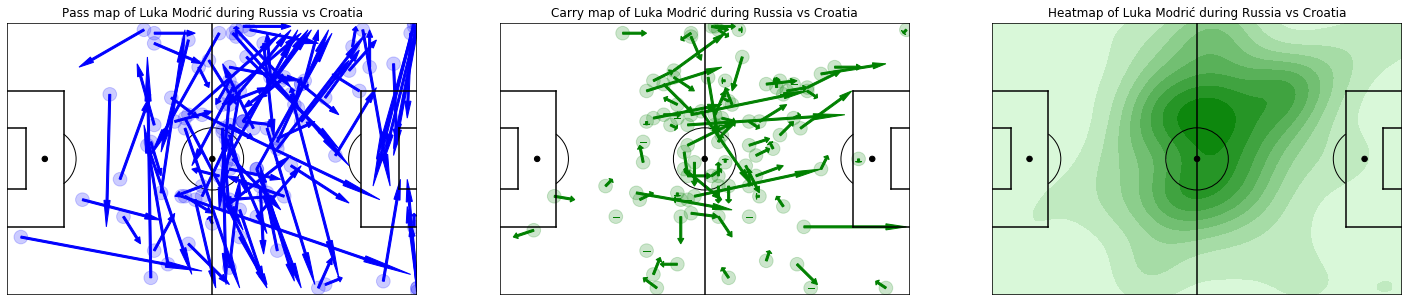

In [12]:
# Filter events for selected match
match = select_match.value
if match != "All":
    home_team, away_team = match.split(" vs ")
    match_id = matches_df[(matches_df.home_team_home_team_name==home_team) & (matches_df.away_team_away_team_name==away_team)].match_id.iloc[0]
    events_to_plot = player_events_df[player_events_df.match_id==match_id]
else:
    events_to_plot = player_events_df

# Initialize figure
fig = plt.figure(figsize=(25, 5))

# Draw pass map
ax1 = fig.add_subplot(1,3,1)
fig, ax1 = create_arrow_map(events=events_to_plot, event_type="Pass", match=match, fig=fig, ax=ax1, pitch_length=pitch_length, pitch_width=pitch_width)

# Draw carry map
ax2 = fig.add_subplot(1,3,2)
fig, ax2 = create_arrow_map(events=events_to_plot, event_type="Carry", match=match, fig=fig, ax=ax2, pitch_length=pitch_length, pitch_width=pitch_width, color="green")

# Draw heat map
ax3 = fig.add_subplot(1,3,3)
fig, ax3 = create_heat_map(events=events_to_plot, match=match, fig=fig, ax=ax3, pitch_length=pitch_length, pitch_width=pitch_width)

### 3.2 - Comparing to his team mates
In this section we will compare how well Luka carried the ball in comparison to his team mates.  Luka to his team mates. ocussing on passes and carries.

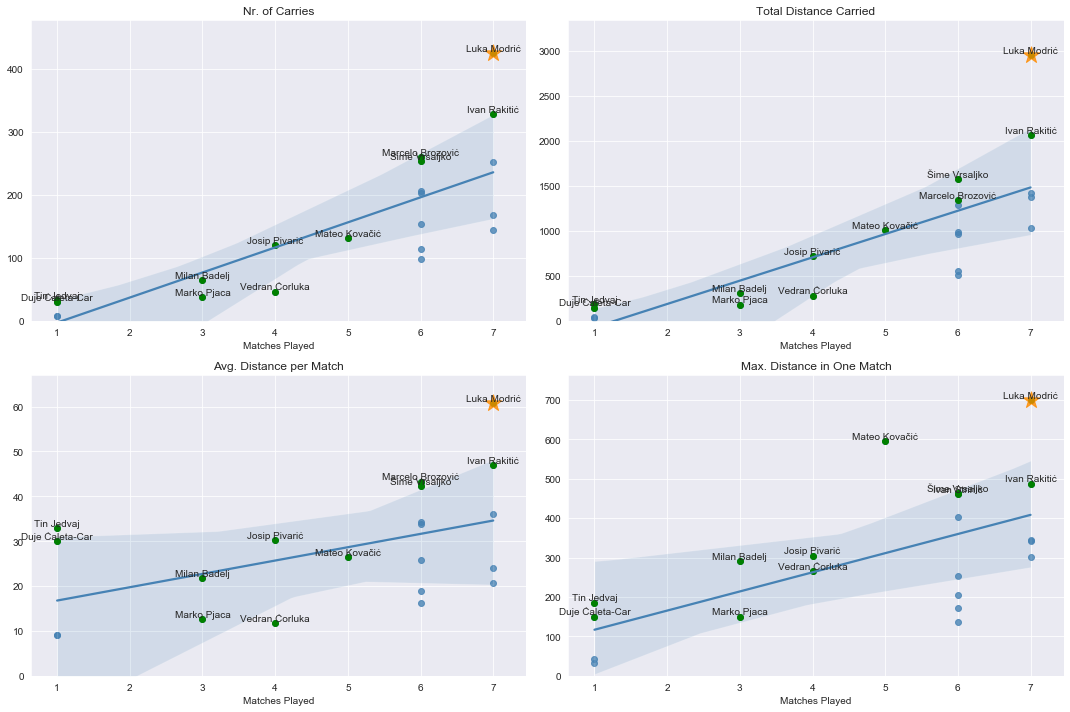

In [16]:
# Filter team events
team_events_df = events_df[events_df.player_name.isin(players)]

# Add carry information
team_events_grouped = add_carry_info(data=team_events_df)

# Plot performance of Modrić compared to his team mates
# Initialize figure
fig = plt.figure(figsize=(15, 10))

# Draw total number of carries
ax1 = fig.add_subplot(2,2,1)
fig, ax1 = create_extended_regplot(data=team_events_grouped, x="Matches Played", y="Nr. of Carries", top_n=2, player_to_highlight=player, fig=fig, ax=ax1)

# Draw total distance carried
ax2 = fig.add_subplot(2,2,2)
fig, ax2 = create_extended_regplot(data=team_events_grouped, x="Matches Played", y="Total Distance Carried", top_n=2, player_to_highlight=player, fig=fig, ax=ax2)

# Draw average distance carried
ax3 = fig.add_subplot(2,2,3)
fig, ax3 = create_extended_regplot(data=team_events_grouped, x="Matches Played", y="Avg. Distance per Match", top_n=2, player_to_highlight=player, fig=fig, ax=ax3)

# Draw maximum distance carried during a single match
ax4 = fig.add_subplot(2,2,4)
fig, ax4 = create_extended_regplot(data=team_events_grouped, x="Matches Played", y="Max. Distance in One Match", top_n=2, player_to_highlight=player, fig=fig, ax=ax4)

fig.tight_layout()

### 3.3 - Comparing to all other players

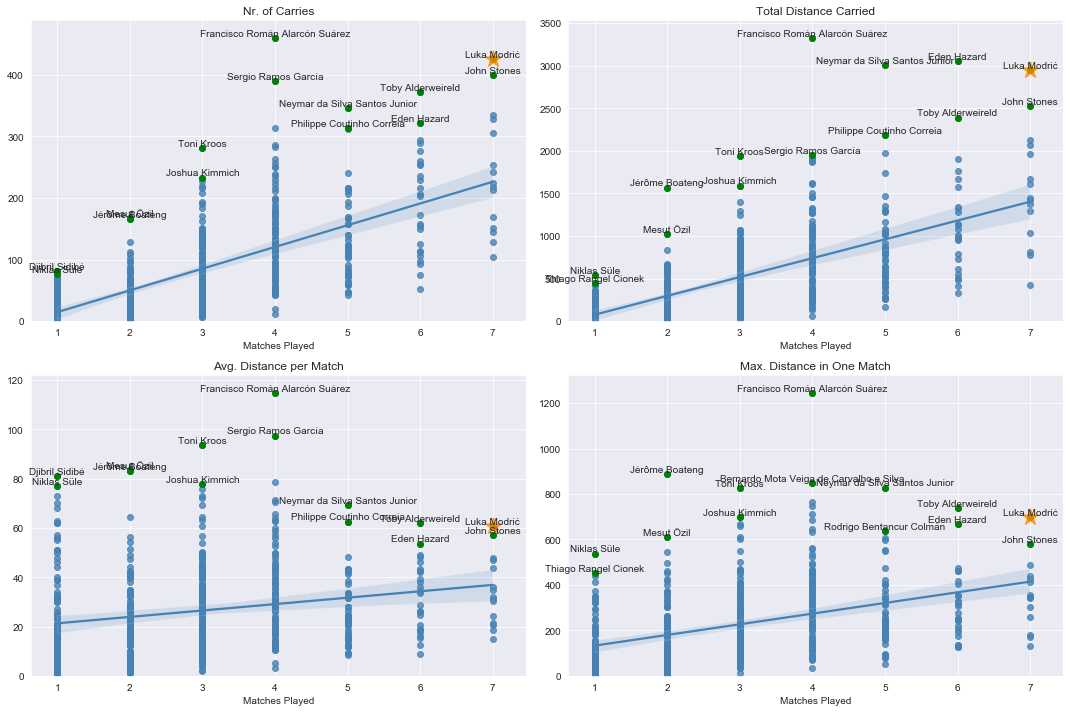

In [14]:
# Add carry information
events_df_grouped = add_carry_info(data=events_df)

# Plot performance of Modrić compared to his team mates
# Initialize figure
fig = plt.figure(figsize=(15, 10))

# Draw total number of carries
ax1 = fig.add_subplot(2,2,1)
fig, ax1 = create_extended_regplot(data=events_df_grouped, x="Matches Played", y="Nr. of Carries", top_n=2, player_to_highlight=player, fig=fig, ax=ax1)

# Draw total distance carried
ax2 = fig.add_subplot(2,2,2)
fig, ax2 = create_extended_regplot(data=events_df_grouped, x="Matches Played", y="Total Distance Carried", top_n=2, player_to_highlight=player, fig=fig, ax=ax2)

# Draw average distance carried
ax3 = fig.add_subplot(2,2,3)
fig, ax3 = create_extended_regplot(data=events_df_grouped, x="Matches Played", y="Avg. Distance per Match", top_n=2, player_to_highlight=player, fig=fig, ax=ax3)

# Draw maximum distance carried during a single match
ax4 = fig.add_subplot(2,2,4)
fig, ax4 = create_extended_regplot(data=events_df_grouped, x="Matches Played", y="Max. Distance in One Match", top_n=2, player_to_highlight=player, fig=fig, ax=ax4)

fig.tight_layout()